In [84]:
import pandas as pd
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from kaggle.api.kaggle_api_extended import KaggleApi
import seaborn as sns

In [85]:
api = KaggleApi()
api.authenticate()

In [86]:
#api.competition_download_file('nlp-getting-started', 'train.csv', path='./')
#api.competition_download_file('nlp-getting-started', 'test.csv', path='./')

In [87]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [88]:
duplicates = df_train.duplicated(subset = ['text'])
df_train[duplicates]

,id,keyword,location,text,target
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,238,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
...,...,...,...,...,...
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [89]:
df_train.target.mean()

0.4296597924602653

In [90]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [91]:
remove = ['id','keyword','location']
df_train = df_train.drop(remove, axis=1)

In [92]:
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [93]:
nlp = en_core_web_sm.load()

In [94]:
STOP_WORDS.add("-PRON-")
STOP_WORDS.add("&amp")
STOP_WORDS.add('\n')
STOP_WORDS.add('&lt')
STOP_WORDS.add('s')
STOP_WORDS.add(' +')

In [95]:
def cleaning_text_lemma(text):
    #return text
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = text.replace('#','hastag ')
    text = ''.join(char for char in text if char.isalnum() or char == ' ')
    text = text.replace(" +"," ").lower().strip()
    text = nlp(text)
    lemma = ' '.join([token.lemma_ for token in text if token.lemma_ not in STOP_WORDS])
    return lemma

def cleaning_text(text):
    #return text
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = text.replace('#','hastag ')
    text = text.replace(r"&amp;", ' ')
    text = text.replace(r"\n", ' ')
    text = text.replace(r" +", ' ')
    text = ''.join(char for char in text if char.isalnum() or char == ' ')
    text = text.replace(" +"," ").lower().strip()
    return text

def cleaning_bert(text):
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’#]))''', " ", text)
    text = text.replace(r"&amp;", ' ')
    text = text.replace(r"\n", ' ')
    text = text.replace(r" +", ' ')
    text = ''.join(char for char in text if char.isalnum() or char == ' ')
    text = text.replace(" +"," ").lower().strip()
    return text

In [96]:
df_train_clean_lemma = df_train.copy()
df_train_clean = df_train.copy()
df_train_bert = df_train.copy()

In [97]:
df_train_clean_lemma['text_clean'] = df_train_clean_lemma.text.apply(cleaning_text_lemma)
df_train_clean['text_clean'] = df_train_clean.text.apply(cleaning_text)
df_train_bert['text_clean'] = df_train_bert.text.apply(cleaning_bert)

In [98]:
duplicates = df_train_clean_lemma.duplicated(subset = ['text_clean'])
df_train_clean_lemma[duplicates]

,text,target,text_clean
48,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,check hastag nsfw
106,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,320 ir icemoon aftershock djicemoon has...
114,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4...,0,320 ir icemoon aftershock djicemoon has...
115,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,320 ir icemoon aftershock djicemoon has...
116,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/e1...,0,320 ir icemoon aftershock djicemoon has...
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home
7609,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest control wild fire calif...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5 km volcano hawaii
7611,Police investigating after an e-bike collided ...,1,police investigate ebike collide car little po...


In [99]:
df_train_clean.drop_duplicates(subset=['text_clean'],inplace=True).reset_index(drop=True)

AttributeError: 'NoneType' object has no attribute 'reset_index'

In [ ]:
duplicates = df_train_clean.duplicated(subset = ['text_clean','target'])
df_train_clean[duplicates]

In [ ]:
df_train_clean_lemma.drop_duplicates(subset=['text_clean'],inplace=True).reset_index(drop=True)

In [ ]:
duplicates = df_train_clean_lemma.duplicated(subset=['text_clean'])
df_train_clean_lemma[duplicates]

In [66]:
for ligne in range(len(df_train_clean['text_clean'])):
    print(df_train_clean['text_clean'][ligne])

our deeds are the reason of this hastag earthquake may allah forgive us all
forest fire near la ronge sask canada
all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
13000 people receive hastag wildfires evacuation orders in california
just got sent this photo from ruby hastag alaska as smoke from hastag wildfires pours into a school
hastag rockyfire update  california hwy 20 closed in both directions due to lake county fire  hastag cafire hastag wildfires
hastag flood hastag disaster heavy rain causes flash flooding of streets in manitou colorado springs areas
im on top of the hill and i can see a fire in the woods
theres an emergency evacuation happening now in the building across the street
im afraid that the tornado is coming to our area
three people died from the heat wave so far
haha south tampa is getting flooded hah wait a second i live in south tampa what am i gonna do what am i gonna do fvck hastag

KeyError: 48

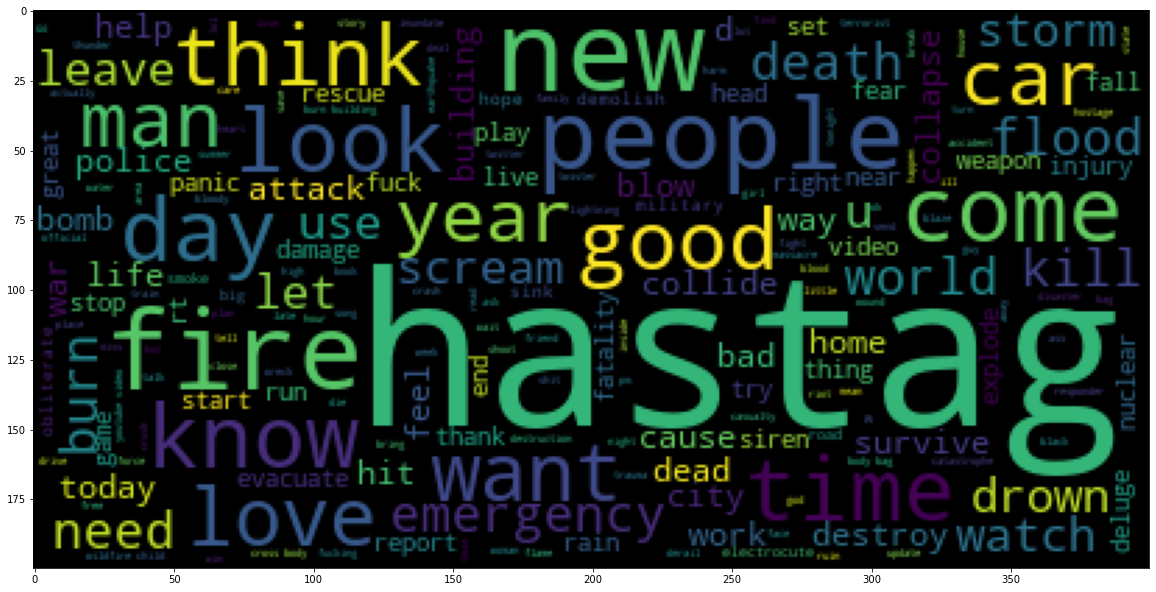

In [32]:
text_lemma = []
wd = WordCloud()
for c in df_train_clean_lemma.text_clean.value_counts().index:
    text_lemma.extend(c)
text_lemma = ''.join(text_lemma)
cloud = wd.generate(text_lemma)
plt.figure(figsize=(20,20))
plt.imshow(cloud)
plt.show()

In [33]:
seqlen_lemma = df_train_clean_lemma.text.apply(lambda x: len(x.split()))

C:\Users\froge\.conda\envs\gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='text', ylabel='Density'>

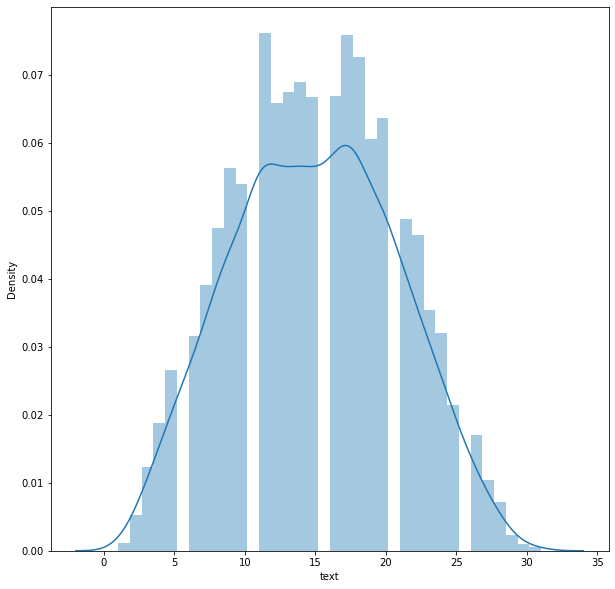

In [34]:
plt.figure(figsize=(10,10))
sns.distplot(seqlen_lemma)

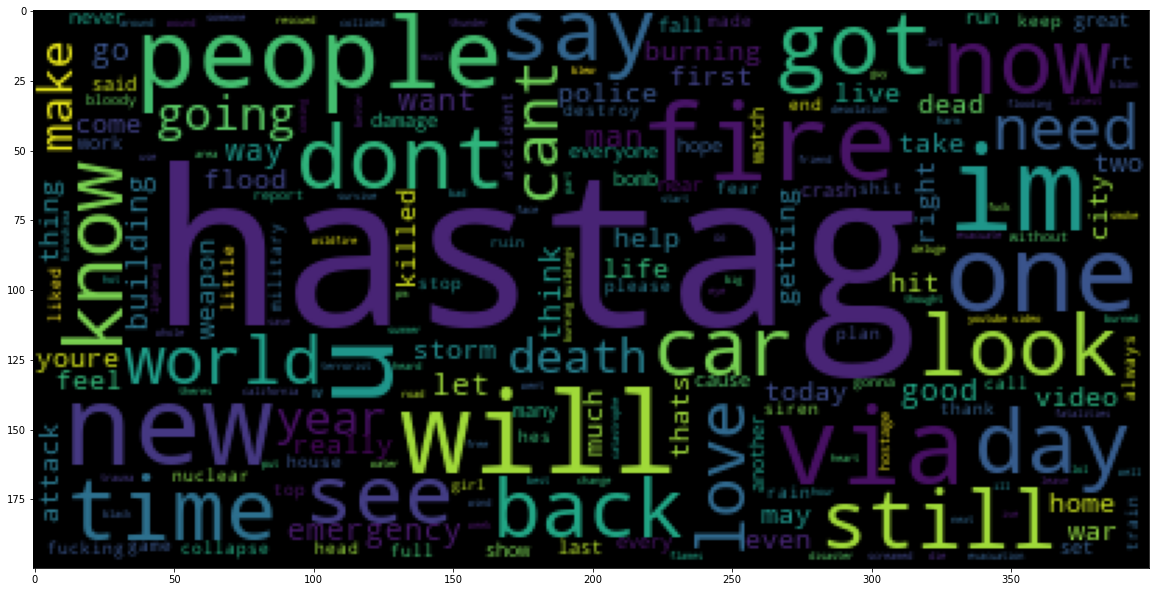

In [35]:
text = []
wd = WordCloud()
for c in df_train_clean.text_clean.value_counts().index:
    text.extend(c)
text = ''.join(text)
cloud = wd.generate(text)
plt.figure(figsize=(20,20))
plt.imshow(cloud)
plt.show()

In [36]:
seqlen = df_train_clean.text.apply(lambda x: len(x.split()))

C:\Users\froge\.conda\envs\gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='text', ylabel='Density'>

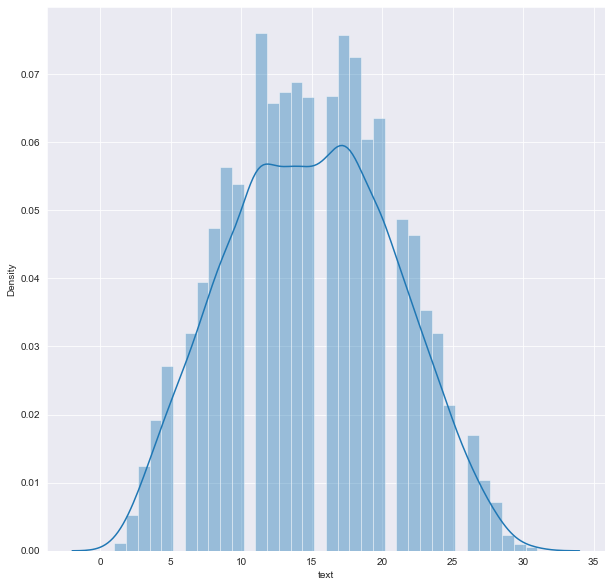

In [37]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
sns.distplot(seqlen)

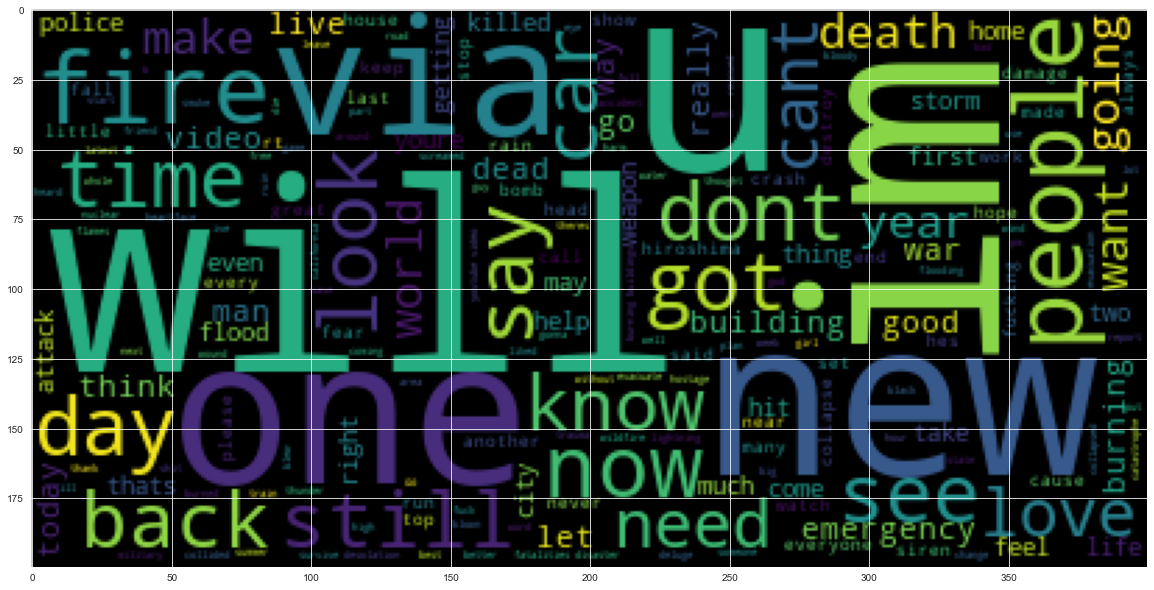

In [38]:
text = []
wd = WordCloud()
for c in df_train_bert.text_clean.value_counts().index:
    text.extend(c)
text = ''.join(text)
cloud = wd.generate(text)
plt.figure(figsize=(20,20))
plt.imshow(cloud)
plt.show()

In [39]:
seqlen = df_train_bert.text.apply(lambda x: len(x.split()))

C:\Users\froge\.conda\envs\gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='text', ylabel='Density'>

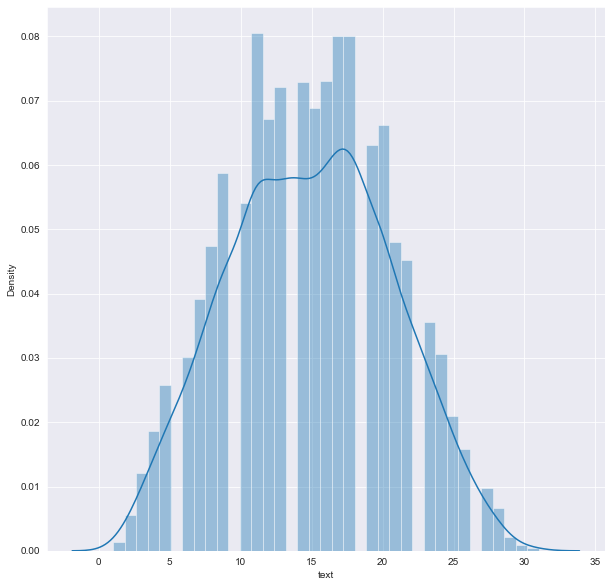

In [40]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
sns.distplot(seqlen)

In [41]:
df_train_clean_lemma.to_csv('df_train_clean_lemma.csv',index=False)
df_train_clean.to_csv('df_train_clean.csv',index=False)
df_train_bert.to_csv('df_train_bert.csv',index=False)

In [42]:
import collections

In [43]:
def hastag(text):
    text_list = re.findall('#(\w+)', text)
    for i in range(len(text_list)):
        text_list[i] = text_list[i].replace('#','').lower()
    text_list = ' '.join([str(elem) for elem in text_list ])
    return text_list
   

In [44]:
df_hastag = df_train.copy()

In [45]:
df_hastag["hastag"] = df_hastag.text.apply(hastag)

In [46]:
df_hastag.head(20)

,text,target,hastag
0,Our Deeds are the Reason of this #earthquake M...,1,earthquake
1,Forest fire near La Ronge Sask. Canada,1,
2,All residents asked to 'shelter in place' are ...,1,
3,"13,000 people receive #wildfires evacuation or...",1,wildfires
4,Just got sent this photo from Ruby #Alaska as ...,1,alaska wildfires
5,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire cafire wildfires
6,#flood #disaster Heavy rain causes flash flood...,1,flood disaster
7,I'm on top of the hill and I can see a fire in...,1,
8,There's an emergency evacuation happening now ...,1,
9,I'm afraid that the tornado is coming to our a...,1,


In [47]:
df_count_one = df_hastag[df_hastag.target == 1].hastag
df_count_one = df_count_one.to_frame()
df_count_zero = df_hastag[df_hastag.target == 0].hastag
df_count_zero = df_count_zero.to_frame()
df_count_one.reset_index(drop=True, inplace=True)
df_count_zero.reset_index(drop=True, inplace=True)

In [48]:
ligne = []
one = []
zero = []
for row in range(len(df_count_one)):
        ligne = df_count_one.hastag[row]
        one.append(ligne)
        ligne = df_count_zero.hastag[row]
        zero.append(ligne)

In [49]:
txt_one = " ".join(one)
txt_zero = " ".join(zero)

In [50]:
counts = collections.Counter(txt_one.split())
counts.most_common()

[('news', 56),
 ('hiroshima', 22),
 ('earthquake', 19),
 ('hot', 13),
 ('prebreak', 13),
 ('best', 13),
 ('japan', 11),
 ('india', 10),
 ('yyc', 10),
 ('breaking', 9),
 ('worldnews', 9),
 ('world', 9),
 ('isis', 9),
 ('sismo', 9),
 ('abstorm', 9),
 ('islam', 9),
 ('disaster', 8),
 ('wildfire', 8),
 ('terrorism', 8),
 ('fukushima', 8),
 ('mh370', 7),
 ('bbc', 7),
 ('genocide', 7),
 ('wx', 7),
 ('okwx', 7),
 ('hailstorm', 7),
 ('nuclear', 7),
 ('rohingya', 6),
 ('cnn', 6),
 ('africa', 6),
 ('antioch', 6),
 ('bestnaijamade', 6),
 ('wildfires', 5),
 ('newyork', 5),
 ('mumbai', 5),
 ('wmata', 5),
 ('myanmar', 5),
 ('sittwe', 5),
 ('drought', 5),
 ('libya', 5),
 ('pakistan', 5),
 ('science', 5),
 ('socialnews', 5),
 ('rockyfire', 4),
 ('flood', 4),
 ('california', 4),
 ('manchester', 4),
 ('accident', 4),
 ('tcot', 4),
 ('irandeal', 4),
 ('usa', 4),
 ('weather', 4),
 ('us', 4),
 ('zionist', 4),
 ('terrorist', 4),
 ('phoenix', 4),
 ('strategicpatience', 4),
 ('usgs', 4),
 ('hostages', 4),
 ('

In [51]:
counts = collections.Counter(txt_zero.split())
counts.most_common()

[('hot', 18),
 ('prebreak', 17),
 ('best', 17),
 ('jobs', 14),
 ('nowplaying', 13),
 ('gbbo', 12),
 ('job', 12),
 ('hiring', 10),
 ('islam', 10),
 ('news', 9),
 ('edm', 8),
 ('dnb', 8),
 ('beyhive', 8),
 ('directioners', 8),
 ('fashion', 8),
 ('rt', 7),
 ('dubstep', 7),
 ('trapmusic', 7),
 ('dance', 7),
 ('ices', 7),
 ('handbag', 7),
 ('military', 6),
 ('nursing', 6),
 ('armageddon', 5),
 ('mtvhottest', 5),
 ('kindle', 5),
 ('womens', 5),
 ('seattle', 5),
 ('technology', 5),
 ('np', 5),
 ('emmerdale', 5),
 ('soundcloud', 5),
 ('animalrescue', 5),
 ('nsfw', 4),
 ('lgbt', 4),
 ('tbt', 4),
 ('bb17', 4),
 ('irandeal', 4),
 ('chemical', 4),
 ('dependency', 4),
 ('course', 4),
 ('tubestrike', 4),
 ('free', 4),
 ('prophetmuhammad', 4),
 ('afterlife', 4),
 ('7', 4),
 ('ramag', 4),
 ('models', 4),
 ('mayhem', 4),
 ('mets', 3),
 ('pbban', 3),
 ('love', 3),
 ('us', 3),
 ('bluejays', 3),
 ('savebees', 3),
 ('business', 3),
 ('harrybecareful', 3),
 ('cool', 3),
 ('tech', 3),
 ('listen', 3),
 ('wors

In [52]:
df_hastag["noH"] = (df_hastag.hastag == '').astype(int)
df_hastag.head(10)

,text,target,hastag,noH
0,Our Deeds are the Reason of this #earthquake M...,1,earthquake,0
1,Forest fire near La Ronge Sask. Canada,1,,1
2,All residents asked to 'shelter in place' are ...,1,,1
3,"13,000 people receive #wildfires evacuation or...",1,wildfires,0
4,Just got sent this photo from Ruby #Alaska as ...,1,alaska wildfires,0
5,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire cafire wildfires,0
6,#flood #disaster Heavy rain causes flash flood...,1,flood disaster,0
7,I'm on top of the hill and I can see a fire in...,1,,1
8,There's an emergency evacuation happening now ...,1,,1
9,I'm afraid that the tornado is coming to our a...,1,,1


In [53]:
df_hastag.groupby('noH').target.mean()

noH
0    0.492255
1    0.411073
Name: target, dtype: float64

In [41]:
df_hastag.groupby('noH').target.count()

noH
0    1743
1    5870
Name: target, dtype: int64

<AxesSubplot:xlabel='noH', ylabel='target'>

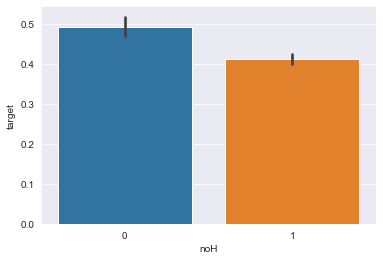

In [42]:
sns.barplot(data=df_hastag,x='noH', y='target')